In [3]:
% matplotlib inline

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy.stats import sem, ttest_ind
from spread import variance, standard_deviation, zipped_z_scores, z_scores
from scipy.stats import linregress

In [5]:
pd.options.display.max_rows = 500

In [6]:
mri_df = pd.read_csv('oasis_longitudinal_shishir.csv')
mri_df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [7]:
# drop NAN
mri_df_drop_nan = mri_df.dropna(how='any')
mri_df_drop_nan.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,0.0,1689,0.712,1.039


In [8]:
grouped_distinct = mri_df_drop_nan.groupby(['Subject ID', 'M/F']).count().reset_index()
grouped_distinct.head()

,Subject ID,M/F,MRI ID,Group,Visit,MR Delay,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,M,2,2,2,2,2,2,2,2,2,2,2,2,2
1,OAS2_0004,F,2,2,2,2,2,2,2,2,2,2,2,2,2
2,OAS2_0005,M,3,3,3,3,3,3,3,3,3,3,3,3,3
3,OAS2_0008,F,2,2,2,2,2,2,2,2,2,2,2,2,2
4,OAS2_0009,M,2,2,2,2,2,2,2,2,2,2,2,2,2


In [9]:
grouped_distinct_count_gender = grouped_distinct.groupby(['M/F']).count()
gender_count_df = grouped_distinct_count_gender.reset_index()[['Subject ID', 'M/F']]
gender_count_df = gender_count_df.rename(columns = {'Subject ID' : 'Gender Count'})
gender_count_df = gender_count_df.set_index(['M/F'])
gender_count_df

,Gender Count
M/F,
F,84
M,58


<BarContainer object of 2 artists>

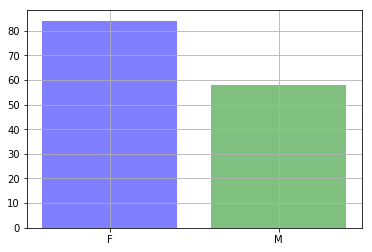

In [10]:
gender_bar_x_axis = gender_count_df.index
plt.grid()
plt.bar(gender_bar_x_axis, gender_count_df['Gender Count'], alpha=0.5, align="center", color = ['b','g'])

In [11]:
# By group count
grouped_distinct_count_gender = grouped_distinct.groupby(['M/F']).count()
gender_count_df = grouped_distinct_count_gender.reset_index()[['Subject ID', 'M/F']]
gender_count_df = gender_count_df.rename(columns = {'Subject ID' : 'Gender Count'})
gender_count_df = gender_count_df.set_index(['M/F'])
gender_count_df

,Gender Count
M/F,
F,84
M,58


In [12]:
grouped_group = mri_df_drop_nan.groupby(['Subject ID', 'Group']).count().reset_index()
grouped_distinct_count_group = grouped_group.groupby(['Group']).count()
group_count_df = grouped_distinct_count_group.reset_index()[['Subject ID', 'Group']]
group_count_df = group_count_df.rename(columns = {'Subject ID' : 'Group Count'})
group_count_df = group_count_df.set_index(['Group'])
group_count_df

,Group Count
Group,
Converted,14
Demented,56
Nondemented,72


<BarContainer object of 3 artists>

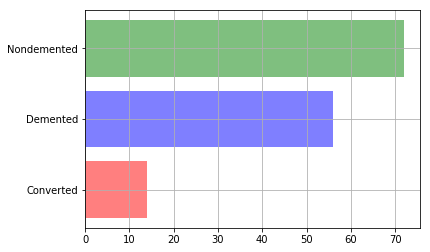

In [13]:
group_bar_x_axis = group_count_df.index
plt.grid()
plt.barh(group_bar_x_axis, group_count_df['Group Count'], alpha=0.5, align="center", color = ['r','b','g'])

In [14]:
# selecting latest visit record
bins = [60,66,71,76,81,86,91,100]
etiv_bins = [1000, 1300, 1600, 1900, 2200]
age_group = ['60-65','66-70','71-75','76-80','81-85','86-90','91+']
etiv_group = ['1000-1299', '1300-1599', '1600-1899', '1900+']
latest_visit_df = mri_df_drop_nan.sort_values('Visit', ascending=False).drop_duplicates('Subject ID').sort_index()
latest_visit_df['Age Group'] = pd.cut(latest_visit_df['Age'], bins = bins, labels=age_group)
latest_visit_df['eTIV Group'] = pd.cut(latest_visit_df['eTIV'], bins = etiv_bins, labels=etiv_group)
latest_visit_df.sort_values(['eTIV']).head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Age Group,eTIV Group
282,OAS2_0138,OAS2_0138_MR2,Nondemented,2,846,F,R,75,16,2.0,28.0,0.0,1106,0.767,1.587,71-75,1000-1299
162,OAS2_0075,OAS2_0075_MR2,Demented,2,567,F,R,75,8,5.0,22.0,0.5,1143,0.741,1.535,71-75,1000-1299
202,OAS2_0096,OAS2_0096_MR2,Nondemented,2,778,F,R,91,13,3.0,28.0,0.0,1165,0.736,1.506,86-90,1000-1299
77,OAS2_0039,OAS2_0039_MR2,Demented,2,486,F,R,83,18,2.0,25.0,0.5,1179,0.733,1.488,81-85,1000-1299
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,0.0,1200,0.718,1.462,86-90,1000-1299


In [15]:
#Subject count on age group
grouped_age = latest_visit_df.groupby(['Age']).count()['Subject ID'].reset_index()
sum(grouped_age['Subject ID'])

142

<BarContainer object of 7 artists>

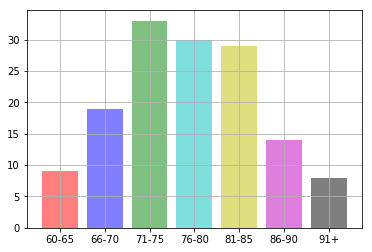

In [16]:
# bar chart for age count
grouped_age['Age Group'] = pd.cut(grouped_age['Age'], bins = bins, labels=age_group)
grouped_age_count = pd.DataFrame(grouped_age.groupby(['Age Group']).sum()['Subject ID'])
grouped_age_count.index
plt.grid()
plt.bar(grouped_age_count.index, grouped_age_count['Subject ID'], alpha=0.5, align="center", color = ['r','b','g','c','y','m','k'])

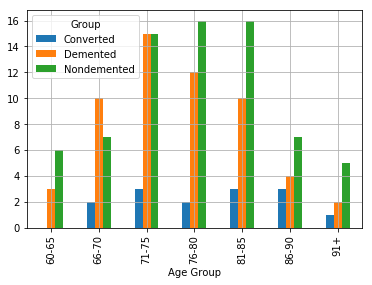

In [17]:
latest_visit_df_grouped = latest_visit_df.groupby(['Age Group','Group']).count()['Subject ID'].fillna(0).unstack()
#latest_visit_df_grouped
latest_visit_df_grouped.plot(kind = 'bar', stacked = False, grid = True)

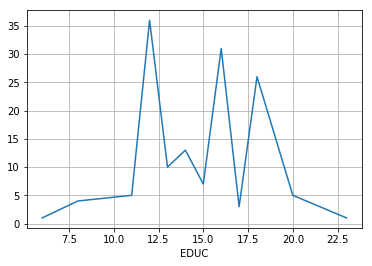

In [18]:
#line chart 
education_grouped = latest_visit_df.groupby(['EDUC']).count()['Subject ID']
education_grouped.plot(kind = 'line', grid=True)

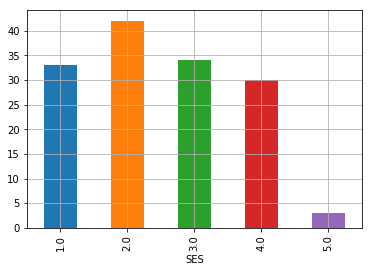

In [19]:
education_grouped = latest_visit_df.groupby(['SES']).count()['Subject ID']
education_grouped.plot(kind = 'bar', grid = True)

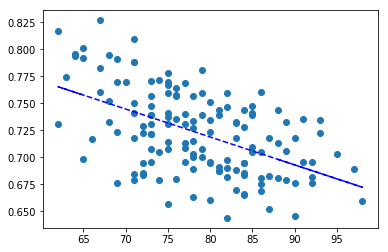

In [49]:
#SES vs EDUC
SES_EDUC_DF = pd.DataFrame(latest_visit_df[['Age', 'nWBV']])
#SES_EDUC_DF = SES_EDUC_DF.set_index('EDUC')
SES_EDUC_DF = SES_EDUC_DF.reset_index()
#SES_EDUC_DF
#SES_EDUC_DF.plot.scatter(x='Age',y='nWBV')

(slope, intercept, _, _, _) = linregress(latest_visit_df['Age'], latest_visit_df['nWBV'])
fit = slope * latest_visit_df['Age'] + intercept
#print(fit)
fig, ax = plt.subplots()
ax.plot(latest_visit_df['Age'], latest_visit_df['nWBV'], linewidth=0, marker='o')
ax.plot(latest_visit_df['Age'], fit, 'b--')

plt.show()


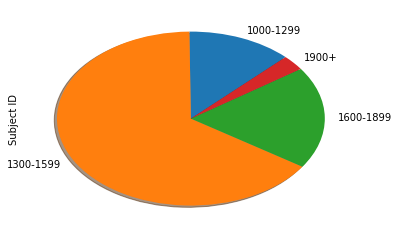

In [21]:
education_grouped = latest_visit_df.groupby(['eTIV Group']).count()['Subject ID']
education_grouped.plot(kind = 'pie', grid=True, shadow=True, startangle=45)

In [50]:
def summarize(title, arr):
    print(f"Summarizing {title}")
    print(f"Variance: {variance(arr)}")
    print(f"Standard Deviation: {standard_deviation(arr)}")
    print("======")

In [51]:
summarize("Age", latest_visit_df['Age'])

Summarizing Age
Variance: 61.31070224161871
Standard Deviation: 7.830115084825938
